In [1]:
## Importing all the important stuff
from dat_to_tif import dat_to_tif
import numpy as np
import os
from dat_from_file import dat_from_file
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from scipy.fft import fft, ifft, ifftshift, fftshift


def read_tif(fname):
    im = Image.open(fname)
    print('IN: {} [Image size: {}, Image mode: {}]'.format(fname, im.size, im.mode))
    return im


In [2]:
## Raw dat input directory
# Change this depending on the run
spool_directory = '/home/paul/Documents/SAXS-WAXS_test_data/raw/Nigel_Naked_Test2_Fine_run2/spool/SpoolDirectory'
## Tif output directory
# Change this depending on the run
tif_directory = '/home/paul/Documents/SAXS-WAXS_test_data/fout'
spool_dirs = 8 # input number of spool directories
spool_dirs_i = [0, 1, 2, 3, 4, 5, 6, 7, 8] #  Need to automate this line
print(spool_dirs_i)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [4]:
## Loop to convert files to tif
for dir_num in spool_dirs_i:
    full_path = spool_directory + str(dir_num)
    dat_from_file(full_path, tif_directory, dim=2048, tifsperdat=3, override=False)

index=1 dat=SpoolData0.dat files = range(256, 259)
index=2 dat=SpoolData1.dat files = range(259, 262)
index=3 dat=SpoolData2.dat files = range(262, 265)
index=4 dat=SpoolData3.dat files = range(265, 268)
index=5 dat=SpoolData4.dat files = range(268, 271)
index=6 dat=SpoolData5.dat files = range(271, 274)
index=7 dat=SpoolData6.dat files = range(274, 277)
index=8 dat=SpoolData7.dat files = range(277, 280)
index=9 dat=SpoolData8.dat files = range(280, 283)
index=10 dat=SpoolData9.dat files = range(283, 286)
index=1 dat=SpoolData10.dat files = range(285, 288)
index=2 dat=SpoolData11.dat files = range(288, 291)
index=3 dat=SpoolData12.dat files = range(291, 294)
index=4 dat=SpoolData13.dat files = range(294, 297)
index=5 dat=SpoolData14.dat files = range(297, 300)
index=6 dat=SpoolData15.dat files = range(300, 303)
index=7 dat=SpoolData16.dat files = range(303, 306)
index=8 dat=SpoolData17.dat files = range(306, 309)
index=9 dat=SpoolData18.dat files = range(309, 312)
index=10 dat=SpoolDat

['Number of lines:', '8268']


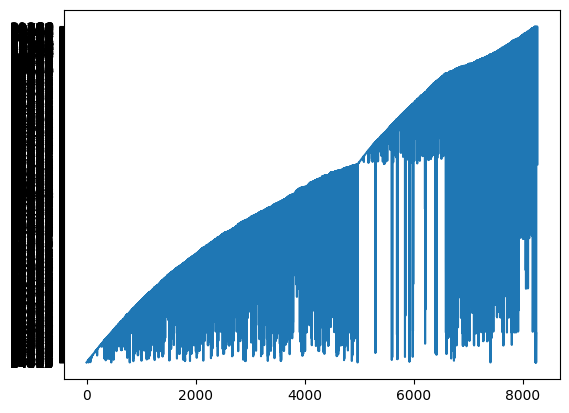

In [3]:
## Log file manipulation
logdir = "./livelogfile.log" #input location of log file
biglog = open(logdir, 'r')
contents = biglog.readlines()
type(contents)
num_lines = len(contents)
print(["Number of lines:", str(num_lines)])
rows = list(range(0, num_lines-1))

I0_column = 20 #Change depending on the column that I0 is in
I0 = list(range(0, num_lines-1)) # work out the length (height) of the I0 array
for row in rows: #loops through rows to populate the I0 array with values from the logfile
    row_n = contents[row] 
    # The lines down here isolate the values from the column.
    split_lines = row_n.split(" ")
    I0_list = str(split_lines[20])
    I0_str = (I0_list.split('"'))
    I0[row] = I0_str[1] #populates the I0 array with values from the log
plt.plot(rows, I0)
plt.show()

In [4]:
# Split the dark frames from the actualy data??

## Set up a DF correction array to subract from the data below
#for D in D_frames:
#    read_tif()
## For now (testing purposes) we can just make the dark field counts be 300
DF_mean = 300

In [9]:
# The initial reconstruction should be done here. We need to pick a test tiff to decide the location of the region of interest for the phase spectrum.
test_frame = read_tif(tif_directory + '/2.tif')

test_data = np.double(np.array(test_frame, dtype='d'))

# integrated counts
integ = sum(sum(test_data[:] - DF_mean))
print(integ)

IN: /home/paul/Documents/SAXS-WAXS_test_data/fout/2.tif [Image size: (2048, 2048), Image mode: I]
